**Portrait Segmentation Using Mobile-Unet**

Set up the GPU runtime

In [ ]:
 # Check GPU
!nvidia-smi

In [ ]:
# Mount G-drive
from google.colab import drive
drive.mount('/content/drive')

**Imports**

In [ ]:
# Import libraries
import os
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Input,Flatten, concatenate,Reshape, Conv2D, MaxPooling2D, Lambda,Activation,Conv2DTranspose
from keras.layers import UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.regularizers import l1
from keras.optimizers import SGD, Adam
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from random import randint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

In [ ]:
# Keras optimization library
!pip install kito
from kito import reduce_keras_model

**Load dataset**

Load the datset for training the model.

Ensure the images are in **RGB** format and masks (**ALPHA**) have pixel values **0 or 255**.

In [ ]:
# Load the dataset
x_train=np.load("/content/drive/My Drive/custom_seg/custom_img_uint8.npy")
y_train=np.load("/content/drive/My Drive/custom_seg/custom_msk_uint8.npy")

In [ ]:
# Verify the mask shape and values
print(np.unique(y_train))
print(y_train.shape)

# Total number of images
num_images=x_train.shape[0]

Copy pretrained model to local runtime disk. Save the checkpoints to your google drive (safe).

In [ ]:
# Configure save paths and batch size
PRETRAINED='/content/pretrained_model.hdf5'
CHECKPOINT="/content/drive/My Drive/portraint_seg/checkpoints/bilinear_segmodel-{epoch:02d}-{val_loss:.2f}.hdf5"
LOGS='./logs'
BATCH_SIZE=32

**Preprocessing**

Normalize the source images  at runtime; but do not modify the masks

In [ ]:
# Preprocessing function (runtime)
def normalize_batch(imgs):
    if imgs.shape[-1] > 1 :
      return (imgs -  np.array([0.50693673, 0.47721124, 0.44640532])) /np.array([0.28926975, 0.27801928, 0.28596011])
    else:
      return imgs.round()
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.28926975, 0.27801928, 0.28596011])) + np.array([0.50693673, 0.47721124, 0.44640532])
    
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

**Data Generator**

Create a data generator to load images and masks together at runtime. 
Use same seed for performing run-time augmentation for images and masks. Here we use  80/20 tran-val split.

In [ ]:
# Data generator for training and validation

data_gen_args = dict(rescale=1./255,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     validation_split=0.2
                    )

image_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize_batch)
mask_datagen = ImageDataGenerator(**data_gen_args,  preprocessing_function=normalize_batch)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
batch_sz=BATCH_SIZE

# Train-val split (80-20)
num_train=int(num_images*0.8)
num_val=int(num_images*0.2) 


train_image_generator = image_datagen.flow(
    x_train,
    batch_size=batch_sz,
    shuffle=True,
    subset='training',
    seed=seed)

train_mask_generator = mask_datagen.flow(
    y_train,
    batch_size=batch_sz,
    shuffle=True,
    subset='training',
    seed=seed)


val_image_generator = image_datagen.flow(
    x_train, 
batch_size = batch_sz,
shuffle=True,
subset='validation',
seed=seed)

val_mask_generator = mask_datagen.flow(
     y_train,
batch_size = batch_sz,
shuffle=True,
subset='validation',
seed=seed)

                     
# combine generators into one which yields image and masks

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)



**Model Architecture**

Here we use **Mobilent v2** with **depth multiplier 0.5** as encoder (feature extractor).

For the **decoder part**, we have two variants. You can use a upsampling block with either  **Transpose Convolution** or **Upsample2D+Convolution**. In the former case we use a **stride of 2**, whereas in the later we use **resize bilinear** for upsampling, along with Conv2d. Ensure proper **skip connections** between encoder and decoder parts for better results.

In [ ]:
# Convolution block with Transpose Convolution
def deconv_block(tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    
    y = Conv2DTranspose(filters=nfilters, kernel_size=size, strides=2, padding = padding, kernel_initializer = kernel_initializer)(tensor)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Activation("relu")(y)
    
    
    return y

In [ ]:
# Convolution block with Upsampling+Conv2D
def deconv_block_rez(tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    y = UpSampling2D(size = (2,2),interpolation='bilinear')(tensor)
    y = Conv2D(filters=nfilters, kernel_size=(size,size), padding = 'same', kernel_initializer = kernel_initializer)(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Activation("relu")(y)
    
    
    return y

If required, set **finetune** and **pretrained** arguments to **True**.

In [ ]:
# Model architecture
def get_mobile_unet(finetune=False, pretrained=False):
  
    # Load pretrained model (if any)
    if (pretrained):
       model=load_model(PRETRAINED)
       print("Loaded pretrained model ...\n")
       return model
  
    # Encoder/Feature extractor
    mnv2=keras.applications.mobilenet_v2.MobileNetV2(input_shape=(128, 128, 3),alpha=0.5, include_top=False, weights='imagenet')
    
    if (finetune):
      for layer in mnv2.layers[:-3]:
        layer.trainable = False
        
    
    x = mnv2.layers[-4].output

    # Decoder
    x = deconv_block(x, 512)
    x = concatenate([x, mnv2.get_layer('block_13_expand_relu').output], axis = 3)
    
    x = deconv_block(x, 256)
    x = concatenate([x, mnv2.get_layer('block_6_expand_relu').output], axis = 3)
                
    x = deconv_block(x, 128)
    x = concatenate([x, mnv2.get_layer('block_3_expand_relu').output], axis = 3)
    
    x = deconv_block(x, 64)
    x = concatenate([x, mnv2.get_layer('block_1_expand_relu').output], axis = 3)
                

    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', kernel_initializer = 'he_normal')(x)
    #x = UpSampling2D(size = (2,2),interpolation='bilinear')(x)
    #x = Conv2D(filters=32, kernel_size=3, padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
   
    x = Conv2DTranspose(1, (1,1), padding='same')(x)
    x = Activation('sigmoid', name="op")(x)
    
    
    model = Model(inputs=mnv2.input, outputs=x)
    
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3),metrics=['accuracy'])
    return model
  
model=get_mobile_unet()

# Model summary
model.summary()

# Plot model architecture
plot_model(model, to_file='portrait_seg.png')

# Save checkpoints
checkpoint = ModelCheckpoint(CHECKPOINT, monitor='val_loss', verbose=1, save_weights_only=False , save_best_only=True, mode='min')

# Callbacks 
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=15, min_lr=0.000001, verbose=1)
tensorboard = TensorBoard(log_dir=LOGS, histogram_freq=0,
                          write_graph=True, write_images=True)

callbacks_list = [checkpoint, tensorboard,reduce_lr]

3203072/3201480 [==============================] - 0s 0us/step


W0830 07:26:18.797109 140429606139776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2241: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.

W0830 07:26:19.537462 140429606139776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 07:26:19.551194 140429606139776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 16)   64          Conv1[0][0]                      
____________________________________________________________________________________________

NameError: ignored

**Train**

Train the model for **300 epochs** with our custom data generator. Use keras callbacks for **tensorboard** visulaization and **learning rate decay** as shown below. You can resume your training from a previous session by loading the entire **pretrained model** (weights  & optimzer state) as a hdf5 file.

In [ ]:
# Load pretrained model (if any)
model=load_model('/path/to/pretrained_model.hdf5')

In [ ]:
# Train the model
model.fit_generator(
    train_generator,
    epochs=300,
    steps_per_epoch=num_train/batch_sz,
    validation_data=val_generator, 
    validation_steps=num_val/batch_sz,
    use_multiprocessing=True,
    workers=2,
    callbacks=callbacks_list)

**Evaluate**

Evalute the performance of the model on a test data-set.

In [ ]:
# Load a trained model checkpoint
model=load_model('/content/up_super_model-01-0.48.hdf5')

# Load a test dataset
new_xtest=x_train[14958:,...]
new_ytest=y_train[14958:,...]

In [ ]:
# Evaluate model 
score = model.evaluate(np.float32(new_xtest/255.0), np.float32(new_ytest/255.0), verbose=0)
# Print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])


**Optimize**

Using the kito library, you can optimize the model by folding the batch norms. This does not change the model behaviour or accuracy; but helps us to reduce the number of layers.

In [ ]:
# Optimize model by folding batch-norms
model_reduced = reduce_keras_model(model)
model_reduced.save('bilinear_bnoptimized_munet.h5')

**Test**

Test the model on a new portrait image and plot the results.

In [ ]:
# Load a test image
im=Image.open('/content/two.jpeg')

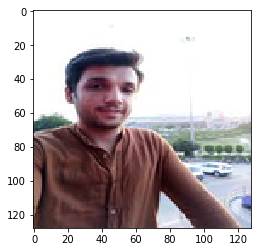

In [ ]:
# Inference
im=im.resize((128,128),Image.ANTIALIAS)
img=np.float32(np.array(im)/255.0)
plt.imshow(img[:,:,0:3])
img=img[:,:,0:3]

# Reshape input and threshold output
out=model_reduced.predict(img.reshape(1,128,128,3))
out=np.float32((out>0.5))

In [ ]:
# Output mask
plt.imshow(np.squeeze(out))

**Export Model**

Export the model to **tflite** format for **real-time** inference on a **smart-phone**.

In [ ]:
# Flatten output and save model
output = model_reduced.output
newout=Flatten()(output)
new_model=Model(model_reduced.input,newout)

new_model.save('bilinear_fin_munet.h5')

# For Float32 Model

converter = tf.lite.TFLiteConverter.from_keras_model_file('/content/bilinear_fin_munet.h5')
tflite_model = converter.convert()
open("bilinear_fin_munet.tflite", "wb").write(tflite_model)

**Post-training Quantization**

We can **reduce the model size and latency** by performing post training quantization. Fixed precison conversion (**UINT8**) allows us to reduce the model size significantly by quantizing the model weights.We can run this model on the mobile **CPU**. The **FP16** (experimental) conversion allows us to reduce the model size by half and the corresponding model can be run directly on mobile **GPU**.

In [ ]:
#For UINT8 Quantization

converter = tf.lite.TFLiteConverter.from_keras_model_file('/content/bilinear_fin_munet.h5')
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open("bilinear_fin_munet_uint8.tflite", "wb").write(tflite_model)


In [ ]:
# Experimental FP16 (TF version >= 1.15) 

! pip uninstall -y tensorflow
! pip install -U tf-nightly

In [ ]:
#For Float16 Quantization 

import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model_file('/content/bilinear_fin_munet.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.lite.constants.FLOAT16]
tflite_model = converter.convert()
open("bilinear_fin_munet_fp16.tflite", "wb").write(tflite_model)

**Plot sample output**

Load the test data as a batch using a numpy array. 

Crop the image using the output mask and plot the result.

In [ ]:
# Load test images and model
model=load_model('/content/deconv_bnoptimized_munet.h5',compile=False)
test_imgs=np.load('/content/test_uint8.npy')
test_imgs= np.float32(np.array(test_imgs)/255.0)

In [ ]:
# Perform batch prediction
out=model.predict(test_imgs)
out=np.float32((out>0.5))

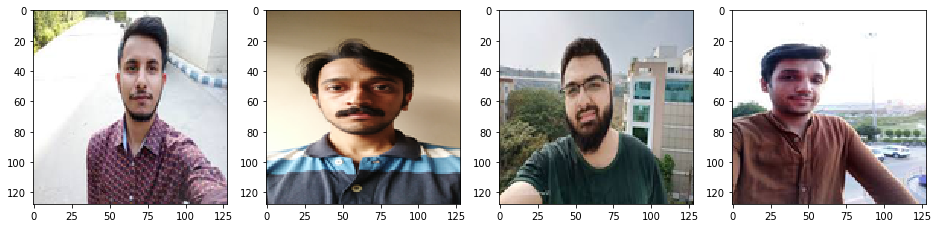

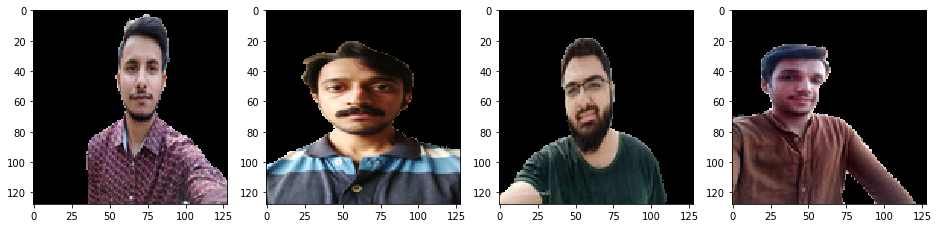

In [ ]:
# Plot the output using matplotlib
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 2

for i in range(1, columns+1):
    img = test_imgs[i-1].squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 2

for i in range(1, columns+1):
    img = out[i-1].squeeze()/255.0
    fig.add_subplot(rows, columns, 4+i)
    plt.imshow(out[i-1]*test_imgs[i-1])
plt.show()